<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, AvgPool2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.resnet import ResNet50 as ResNet

In [3]:
def get_datagen_flow(path, subset):
    
    labels = pd.read_csv(path + 'labels.csv')

    horizontal_flip = False
    vertical_flip = False
    height_shift_range = 0.0
    width_shift_range = 0.0
    rotation_range = 0.0

    if subset=='training':
      #заглушка, по результатам тестирования аугментация дает улучшение метрики при height_shift_range=0.2, но "через раз"
      a=1
      #horizontal_flip = True  
      #vertical_flip = True
      #height_shift_range = 0.2
      #width_shift_range = 0.2
      #rotation_range = 30
    
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255,
                                   horizontal_flip=horizontal_flip, 
                                   vertical_flip=vertical_flip,
                                   height_shift_range = height_shift_range,
                                   width_shift_range = width_shift_range,
                                   rotation_range = rotation_range 
                                 )

    datagen_flow = datagen.flow_from_dataframe(
    labels,        
    path + 'final_files',
    x_col='file_name',
    y_col='real_age',        
    target_size=(224, 224), 
    batch_size=16,           
    class_mode='raw',
    subset=subset,
    seed=12345) 
    
    return datagen_flow

In [4]:
def load_train(path):
    
    return get_datagen_flow(path, 'training')

In [5]:
def load_test(path):
    
    return get_datagen_flow(path, 'validation')

In [6]:
path = '/datasets/faces/'

In [7]:
data = pd.read_csv(path + 'labels.csv')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [9]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


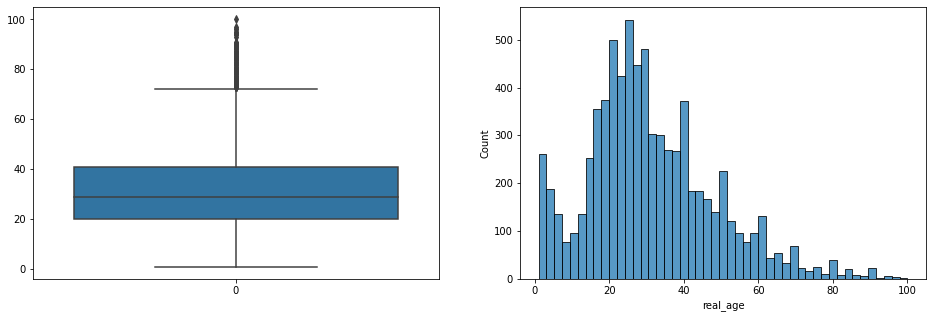

In [17]:
fig, axis = plt.subplots(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data = data['real_age']);

plt.subplot(1, 2, 2)
sns.histplot(data = data,  x='real_age');

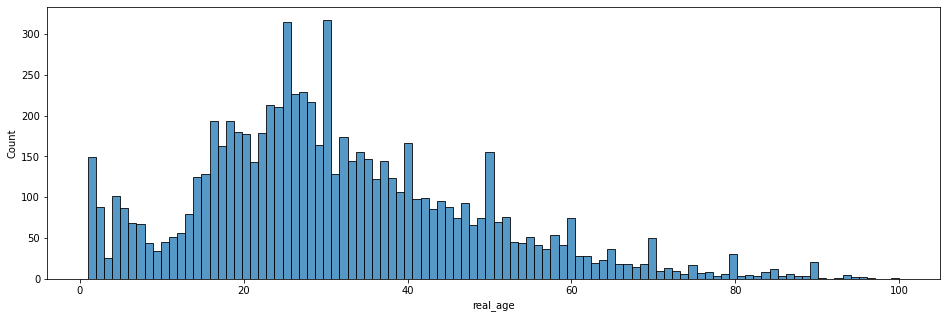

In [16]:
fig, axis = plt.subplots(figsize=(16, 5))
sns.histplot(data = data,  x='real_age', bins=100);

In [11]:
describe_data = data['real_age'].describe()
iqr = (describe_data['75%'] - describe_data['25%'])
lower_line = round(max(describe_data['min'], describe_data['25%'] - round(1.5 * iqr)))
upper_line = round(min(describe_data['max'], describe_data['75%'] + round(1.5 * iqr)))
f'Диапазон "усов" диаграммы размаха {lower_line} - {upper_line}'

'Диапазон "усов" диаграммы размаха 1 - 73'

In [12]:
train_datagen_flow = load_train(path)

Found 5694 validated image filenames.


In [13]:
features_train, target_train = next(train_datagen_flow)

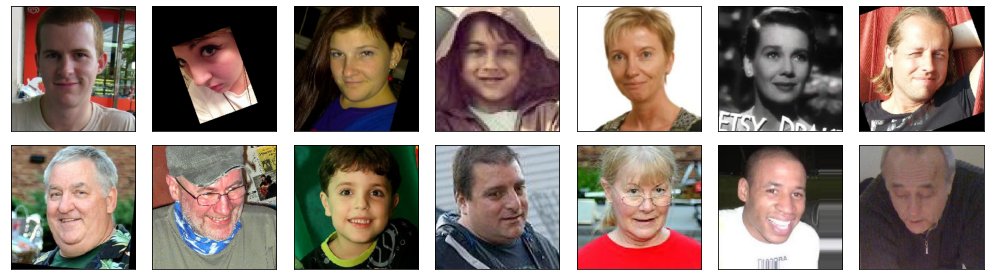

In [14]:
fig = plt.figure(figsize=(14,4))
for i in range(14):
    fig.add_subplot(2, 7, i+1)
    plt.imshow(features_train[i])
 
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**

В датасете 7591 изображение. На них присутствуют люди 1-100 лет, большая часть из них приходится на 20-40 лет, выбросы начинаются с 74 года. Видно, чтоб есть лица как в фас, так и анфас, частично заслоненные, черно-белые фото, что должно улучшить качество модели. К некоторым изображениям применен поворот: "For each image X.jpg, we also provide a corresponding X.jpg_face.jpg which contains the cropped & rotated face with a 40% margin obtained from the Mathias et. al face detector (http://markusmathias.bitbucket.org/2014_eccv_face_detection/) at multiple rotations."

В среднем на каждый возраст от 1 до 100 приходится по 70 фотографий. По диаграмме распределения видно, что  на возрасты, кратные 5/10 (25, 35, 40, 50 и т.д.), приходится больше фото, чем на промежуточные.

Требуется решить задачу регрессии с результатом MAE <= 8. Для оценки достаточности количества изображений можно представить близкую задачу классификации на 15 классов, которая дает похожую точность. Если считать, что на каждый класс нужно 1000 изображений, то для решения данной задачи необходимо 15000 изображений, т.е. в 2 раза больше, чем у нас есть. 

Для решения этой потенциальной проблемы можно будет при обучении поэкспериментировать с аугментациями - отразить по горизонтали, посмещать по горизонтали/вертикали, повернуть до 45 градусов, например. Вертикальное отражение точно использовать не стоит, т.к. в магазине таких кейсов не будет и эта манипуляция только испортит качество.

Аугментация даже одного типа даст в 2 раза больше изображений, что по предварительной оценке данных должно быть достаточно.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python
#resnet50
def create_model(input_shape):

    backbone = ResNet(input_shape=input_shape,
                 include_top=False,
                 weights='imagenet'
                 ) 

    #по результатам тестирования заморозка обучения сильно ухудшает результат
    #backbone.trainable = False
    
    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(learning_rate=0.0001)

    #по результатам обучения наилучшее качество достигается 
    #при optimizer = Adam и loss='mean_squared_error'
    #в сравнении с optimizer='sgd' и/или loss='mean_absolute_error'
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model 
```

```python
#lenet
def create_model(input_shape): 
    model = Sequential()

    model.add(Conv2D(filters=6, kernel_size=(5, 5), input_shape=input_shape, activation='relu', padding='same'))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu'))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Flatten())

    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))

    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model 
```

```python
#vgg16
def create_model(input_shape):

    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    model.summary()

    return model 
```

```python
def train_model(model, train_datagen_flow, val_datagen_flow, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_datagen_flow,
              validation_data=val_datagen_flow,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

Далее публикую результаты обучения и предсказания нейросетей с разными параметрами.

**ResNet50: optimizer='sgd', loss='mean_squared_error'**
````
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 46s - loss: 561.0936 - mae: 17.9897 - val_loss: 382.8111 - val_mae: 15.6071
Epoch 2/5
356/356 - 38s - loss: 554.4091 - mae: 15.7091 - val_loss: 286.8935 - val_mae: 13.4842
Epoch 3/5
356/356 - 38s - loss: 386.6519 - mae: 15.2644 - val_loss: 728.8667 - val_mae: 22.1023
Epoch 4/5
356/356 - 38s - loss: 374.1258 - mae: 14.9737 - val_loss: 286.9218 - val_mae: 13.4783
Epoch 5/5
356/356 - 38s - loss: 358.6966 - mae: 14.6954 - val_loss: 287.0664 - val_mae: 13.4726

119/119 - 9s - loss: 287.0664 - mae: 13.4726
Test MAE: 13.4726
````

**ResNet50: optimizer = Adam, loss='mean_absolute_error'**
```
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 46s - loss: 11.2142 - mae: 11.2109 - val_loss: 19.5433 - val_mae: 19.5404
Epoch 2/5
356/356 - 38s - loss: 7.2526 - mae: 7.2519 - val_loss: 14.3026 - val_mae: 14.2943
Epoch 3/5
356/356 - 38s - loss: 6.0262 - mae: 6.0261 - val_loss: 6.7706 - val_mae: 6.7800
Epoch 4/5
356/356 - 38s - loss: 5.2002 - mae: 5.2005 - val_loss: 7.1405 - val_mae: 7.1455
Epoch 5/5
356/356 - 38s - loss: 4.6406 - mae: 4.6395 - val_loss: 6.4382 - val_mae: 6.4444

119/119 - 10s - loss: 6.4382 - mae: 6.4444
Test MAE: 6.4444
```

**ResNet50: optimizer = Adam, loss='mean_squared_error'**
```
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 48s - loss: 240.4126 - mae: 11.0357 - val_loss: 352.6034 - val_mae: 13.9448
Epoch 2/5
356/356 - 38s - loss: 70.7002 - mae: 6.4099 - val_loss: 129.1203 - val_mae: 8.6743
Epoch 3/5
356/356 - 38s - loss: 40.6703 - mae: 4.9205 - val_loss: 120.1594 - val_mae: 8.1635
Epoch 4/5
356/356 - 38s - loss: 25.7487 - mae: 3.9202 - val_loss: 86.8972 - val_mae: 7.4020
Epoch 5/5
356/356 - 37s - loss: 17.1620 - mae: 3.1992 - val_loss: 72.4371 - val_mae: 6.3724

119/119 - 10s - loss: 72.4371 - mae: 6.3724
Test MAE: 6.3724
```

**ResNet50: optimizer = Adam, loss='mean_squared_error', height_shift_range=0.2**
````
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 98s - loss: 237.8892 - mae: 11.0605 - val_loss: 484.1514 - val_mae: 16.8652
Epoch 2/5
356/356 - 89s - loss: 87.8622 - mae: 7.1675 - val_loss: 134.1102 - val_mae: 8.8578
Epoch 3/5
356/356 - 90s - loss: 59.8314 - mae: 5.9752 - val_loss: 77.8928 - val_mae: 6.5615
Epoch 4/5
356/356 - 89s - loss: 41.4372 - mae: 4.9931 - val_loss: 83.1983 - val_mae: 6.8262
Epoch 5/5
356/356 - 89s - loss: 30.8517 - mae: 4.3311 - val_loss: 70.9674 - val_mae: 6.3086

119/119 - 9s - loss: 70.9674 - mae: 6.3086
Test MAE: 6.3086
````

**LeNet: optimizer = Adam, loss='mean_squared_error'**
````
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 119s - loss: 330.0646 - mae: 14.0149 - val_loss: 270.1703 - val_mae: 12.9333
Epoch 2/5
356/356 - 36s - loss: 278.4079 - mae: 12.8396 - val_loss: 271.4832 - val_mae: 13.2448
Epoch 3/5
356/356 - 36s - loss: 259.8616 - mae: 12.4322 - val_loss: 250.3629 - val_mae: 12.6191
Epoch 4/5
356/356 - 36s - loss: 245.8813 - mae: 12.0361 - val_loss: 239.3731 - val_mae: 12.2287
Epoch 5/5
356/356 - 37s - loss: 237.0804 - mae: 11.8755 - val_loss: 232.6596 - val_mae: 12.0567

119/119 - 9s - loss: 232.6596 - mae: 12.0567
Test MAE: 12.0567

````

**VGG16: optimizer = Adam, loss='mean_squared_error'**
````
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 132s - loss: 365.6194 - mae: 14.6736 - val_loss: 283.0479 - val_mae: 12.7180
Epoch 2/5
356/356 - 39s - loss: 307.6759 - mae: 13.6021 - val_loss: 274.4549 - val_mae: 12.7741
Epoch 3/5
356/356 - 39s - loss: 310.7155 - mae: 13.6696 - val_loss: 300.2069 - val_mae: 14.1619
Epoch 4/5
356/356 - 39s - loss: 291.5188 - mae: 13.2316 - val_loss: 258.1853 - val_mae: 12.4699
Epoch 5/5
356/356 - 38s - loss: 282.5193 - mae: 12.9797 - val_loss: 269.5305 - val_mae: 13.1863

119/119 - 10s - loss: 269.5305 - mae: 13.1863
Test MAE: 13.1863
````

## Анализ обученной модели

Наименьшее значение MAE из всех проработанных мной вариантов дает нейросеть ResNet50 с оптимизатором Adam и функцией потерь MSE. Для улучшения результата возможно использование аугментации со смещением по вертикали на 20% от исходного размера (дает непостоянное уменьшение метрики из-за особенностей вычислений на GPU). Среднее абсолютное отклонение предсказания от реального возраста - 6.37 лет.

Нейросети LeNet и VGG16 дают результат сильно хуже - 12-13 лет, прежде всему, потому что ResNet50 предобучена на ImageNet, а LeNet помимо прочего - устаревшая архитектура. Эти 2 нейросети взяты для сравнения в этом проекте и собраны с нуля в академических целях.

В разделе "Обучение модели" подробно приведены результаты обучения на 5 эпохах, при увеличении количества эпох качество улучшается. При 40 эпохах (при прочих равных) MAE уменьшается до:
* ResNet50 - 5.65;
* LeNet - 12.34;
* VGG16 - 9.15.